# Qubit Optimization for 3-qubit Ising model 

We will be comparing PennyLane-wrapped NumPy *gradient descent optimizer* with that of *TensorFlow* and *PyTorch* for one and the same quantum system. For details on these interfaces, see [pennylane interfaces](https://pennylane.readthedocs.io/en/latest/code/interfaces.html).

Ising model is an example of a system whose optimization landscape is non-convex and hence using gradient descent is not the best solution since the optimization can get stuck in local minimas. Quantum annealing (for example on D-wave system) can be used instead. 

The energy for this system is given by:
$$ H=-\sum_{<i,j>} J_{ij} \sigma_i \sigma_{j}$$

where each spin can be in +1 or -1 state and $J_{ij}$ are nearest neighbour coupling strengths.

For simplicity, we will assume that spin 1 is always in up state (+1 eigenstate of Pauli-Z operator)

> <font color=brown>**NOTE:** To follow along with this tutorial on your own computer, you will require the following dependencies:</font>
    
> - [PyTorch](https://pytorch.org/get-started/locally/) in order to access the PyTorch QNode interface. Follow the link for instructions on the best way to install PyTorch for your system.

> - [TensorFlow](https://www.tensorflow.org/) in order to access the TensorFlow QNode interface. Follow the link for instructions on the best way to install Tensorflow for your system. 


## PennyLane Optimizer

In [1]:
# import PennyLane library
import pennylane as qml
from pennylane import numpy as np

In [2]:
# create our three devices. 
dev1 = qml.device('default.qubit', wires=3)
dev2 = qml.device('default.qubit', wires=3)
dev3 = qml.device('default.qubit', wires=3)

In [3]:
# We can use the GENERAL PennyLane Rot(phi,theta,omega,wires) operation
@qml.qnode(dev1)
def circuit1(p1, p2):
    qml.Rot(p1[0], p1[1], p1[2], wires =1)
    qml.Rot(p2[0], p2[1], p2[2], wires =2)
    return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2) 

Our cost function is the energy of the spin configuration which we will optimize using gradient descent.

Let the coupling matrix be J = [1,-1]

In [4]:
def cost1(var):
    spins = circuit1(var[0], var[1])
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

Lets test these functions for the [1,-1,-1] spin configuration. 

The total energy for this Ising model should be

$H = -1(J_1 \times s_1 \times s_2 + J_2 \times s_2 \times s_3) = -1 (1\times1\times-1 + -1\times-1\times-1) = 2 $


In [5]:
# You can easily guess the angles if you look at the Rot(phi,theta,omega)
t1 = np.array([0, np.pi, 0])    #spin 2 in -1 state
t2 = np.array([0, np.pi, 0])    #spin 3 in -1 state
print(cost1([t1, t2]))

2.0


Now we optimize using the PennyLane NumPy gradient descent optimizer


In [7]:
# initialize the parameters to some random values
pl1 = np.pi*(np.random.ranf(3))
pl2 = np.pi*(np.random.ranf(3))
var_init = np.array([pl1, pl2])
cost_init = cost1(var_init)
print(cost_init)

0.002172558286270143


The minimun energy should be -2 for [1,1,-1] spin configuration, which corresponds to the angles of [0,0,0] and [0,pi,0] for the spin 2 and spin 3 respectively. 

In [8]:
gd = qml.GradientDescentOptimizer(0.4)

var = var_init
var_gd = [var]
cost_gd = [cost_init]

for it in range(100):
    var = gd.step(cost1, var)
    if (it+1) % 5 == 0:
        var_gd.append(var)
        cost_gd.append (cost1(var))
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(it + 1, cost1(var), var),"\n")

Energy after step     5: -0.0755957 | Angles: [[0.0237345  1.24598699 2.87502876]
 [2.69573943 0.70267197 3.11095815]] 

Energy after step    10: -0.8220873 | Angles: [[0.0237345  0.56459218 2.87502876]
 [2.69573943 1.54389983 3.11095815]] 

Energy after step    15: -1.9746499 | Angles: [[0.0237345  0.00378133 2.87502876]
 [2.69573943 2.91601013 3.11095815]] 

Energy after step    20: -1.9998434 | Angles: [[2.37345044e-02 1.30782122e-06 2.87502876e+00]
 [2.69573943e+00 3.12389646e+00 3.11095815e+00]] 

Energy after step    25: -1.9999991 | Angles: [[2.37345044e-02 4.18706394e-10 2.87502876e+00]
 [2.69573943e+00 3.14021652e+00 3.11095815e+00]] 

Energy after step    30: -2.0000000 | Angles: [[2.37345044e-02 1.34249617e-13 2.87502876e+00]
 [2.69573943e+00 3.14148565e+00 3.11095815e+00]] 

Energy after step    35: -2.0000000 | Angles: [[2.37345044e-02 9.85937415e-17 2.87502876e+00]
 [2.69573943e+00 3.14158433e+00 3.11095815e+00]] 

Energy after step    40: -2.0000000 | Angles: [[2.3734504

## Tenserflow Optimizer

In [9]:
# activate TensorFlow and its eager mode
import tensorflow as tf
import tensorflow.contrib.eager as tfe
# to supress TensorFlow warnings from getting printed
tf.logging.set_verbosity(tf.logging.ERROR) 
# check if the eager tenserflow execution is working
tf.enable_eager_execution()
print(tf.executing_eagerly())

True


In [10]:
# the interface is given as an arguemnt when constructing the QNode
@qml.qnode(dev2, interface='tfe')
def circuit2(p1, p2):
        qml.Rot(p1[0], p1[1], p1[2], wires =1)
        qml.Rot(p2[0], p2[1], p2[2], wires =2)
        return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2)

In [11]:
def cost2(var):
    spins = circuit2(var[0], var[1])
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [12]:
# let's test the functions again for our known spin configuration [1,-1,-1]
t1 = tfe.Variable([0, np.pi, 0], dtype = tf.float64)
t2 = tfe.Variable([0, np.pi, 0], dtype = tf.float64)
print(cost2([t1,t2]))

tf.Tensor(2.0, shape=(), dtype=float64)


In [16]:
# initialize the parameters to some random values
tf1 = tfe.Variable(tf.random_uniform([3], 0, np.pi, dtype = tf.float64))
tf2 = tfe.Variable(tf.random_uniform([3], 0, np.pi, dtype = tf.float64))
var_init = [tf1, tf2]
cost_init = cost2(var_init)
print(cost_init)

tf.Tensor(0.03400207083342157, shape=(), dtype=float64)


In [17]:
# optimize using tensorflow optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)

var = var_init
var_tf = [var]
cost_tf = [cost_init]

for i in range(100):
    with tf.GradientTape() as tape:
        loss = cost2([tf1, tf2])
        grads = tape.gradient(loss, [tf1, tf2])

    opt.apply_gradients(zip(grads, [tf1, tf2]), global_step=tf.train.get_or_create_global_step())
    if (i + 1) % 5 == 0:
            var_tf.append([tf1,tf2])
            cost_tf.append (cost2([tf1,tf2]))
            print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(i+1,cost2([tf1,tf2]), [tf1.numpy(),tf2.numpy()]),"\n")

Energy after step     5: -0.0541588 | Angles: [array([0.37079426, 1.44271247, 2.82900002]), array([2.83971081, 0.95696559, 0.83155095])] 

Energy after step    10: -0.1690996 | Angles: [array([0.37079426, 1.22469592, 2.82900002]), array([2.83971081, 1.04543866, 0.83155095])] 

Energy after step    15: -0.3784354 | Angles: [array([0.37079426, 0.97365833, 2.82900002]), array([2.83971081, 1.23771089, 0.83155095])] 

Energy after step    20: -0.7657228 | Angles: [array([0.37079426, 0.67935139, 2.82900002]), array([2.83971081, 1.55504004, 0.83155095])] 

Energy after step    25: -1.2887150 | Angles: [array([0.37079426, 0.38199763, 2.82900002]), array([2.83971081, 1.97014515, 0.83155095])] 

Energy after step    30: -1.6931088 | Angles: [array([0.37079426, 0.1683254 , 2.82900002]), array([2.83971081, 2.37083222, 0.83155095])] 

Energy after step    35: -1.8857891 | Angles: [array([0.37079426, 0.06266963, 2.82900002]), array([2.83971081, 2.66704253, 0.83155095])] 

Energy after step    40: -1

## PyTorch Optimizer

In [18]:
import torch
from torch.autograd import Variable

In [19]:
# the interface is given as an arguemnt when constructing the QNode
@qml.qnode(dev3, interface='torch')
def circuit3(p1, p2):
    qml.Rot(p1[0], p1[1], p1[2], wires =1)
    qml.Rot(p2[0], p2[1], p2[2], wires =2)
    return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2) 

In [20]:
def cost3(var1, var2):
    spins = circuit3(var1, var2)
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [21]:
# let's test the functions again for our known spin configuration [1,-1,-1]
t1=torch.tensor([0, np.pi, 0])
t2=torch.tensor([0, np.pi ,0])
print(cost3(t1, t2))

tensor(2.0000, dtype=torch.float64)


In [31]:
pt1 = Variable((np.pi*torch.rand(3, dtype = torch.float64)), requires_grad = True)
pt2 = Variable((np.pi*torch.rand(3, dtype = torch.float64)), requires_grad = True)
var_init = [pt1, pt2]
cost_init = cost3(pt1, pt2)
print(cost_init)

tensor(0.0257, dtype=torch.float64, grad_fn=<SubBackward0>)


In [32]:
# optimizing using PyTorch optimizer 
opt = torch.optim.Adam(var_init, lr = 0.1)

# define a function to perform one step of the optimization: see explaination below
def closure():
    opt.zero_grad()
    loss = cost3(pt1, pt2)
    loss.backward()
    return loss

var_pt = [var_init]
cost_pt = [cost_init]

for j in range(100):
    opt.step(closure)
    if (j + 1) % 5 == 0:
        pt1, pt2 = opt.param_groups[0]['params']
        costn = cost3(pt1, pt2)
        var_pt.append([pt1, pt2])
        cost_pt.append(costn)
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(j+1,costn, [pt1.detach().numpy(), pt2.detach().numpy()]),"\n")

Energy after step     5: -0.2388403 | Angles: [array([2.43977009, 1.12881382, 0.52679594]), array([1.94815449, 1.11340111, 1.93922613])] 

Energy after step    10: -0.8175243 | Angles: [array([2.43977009, 0.61999048, 0.52679594]), array([1.94815449, 1.57526912, 1.93922613])] 

Energy after step    15: -1.4890582 | Angles: [array([2.43977009, 0.11263163, 0.52679594]), array([1.94815449, 2.0927255 , 1.93922613])] 

Energy after step    20: -1.8157600 | Angles: [array([ 2.43977009, -0.24350071,  0.52679594]), array([1.94815449, 2.62793539, 1.93922613])] 

Energy after step    25: -1.9426479 | Angles: [array([ 2.43977009, -0.23833077,  0.52679594]), array([1.94815449, 3.10053639, 1.93922613])] 

Energy after step    30: -1.9641229 | Angles: [array([ 2.43977009, -0.02873415,  0.52679594]), array([1.94815449, 3.407197  , 1.93922613])] 

Energy after step    35: -1.9226274 | Angles: [array([2.43977009, 0.12585403, 0.52679594]), array([1.94815449, 3.49570397, 1.93922613])] 

Energy after step 

When using the *PyTorch* optimizer, keep in mind that:

1. `loss.backward( )` computes the gradient of the cost function with respect to all parameters (whcih have `requires_grad=True`). 

2. `opt.step( )` performs the parameter update based on this *current* gradient and the learning rate. 

3. `opt.zer_grad( )` sets all the gradients back to zero. It’s important to call this before `loss.backward( )` to avoid the accumulation of  gradients from multiple passes.

Hence, its standard practice to define the `closure( )` function that clears up the old gradient, evaluates the new gradient and passes it onto the optimizer in each step. 

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
x = [0]
for k in range(100):
    if (k + 1) % 5 == 0:
        x.append(k)

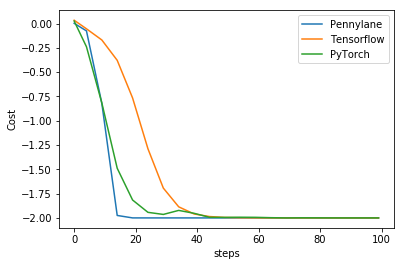

In [35]:
plt.plot(x,cost_gd, label = 'Pennylane')
plt.plot(x,cost_tf, label = 'Tensorflow')
plt.plot(x,cost_pt, label = 'PyTorch')
plt.xlabel("steps")
plt.ylabel("Cost")
plt.legend()
plt.show()

In some runs, you will see the optimization getting stuck in a local minima of energy (usually zero energy). Do not forget to restart the kernel before rerunning the file! 